# Limpieza

In [1]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('2017-18_NBA_salary.csv')
data.head()

,Player,Salary,NBA_Country,NBA_DraftNumber,Age,Tm,G,MP,PER,TS%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Zhou Qi,815615,China,43,22,HOU,16,87,0.6,0.303,...,18.2,19.5,-0.4,0.1,-0.2,-0.121,-10.6,0.5,-10.1,-0.2
1,Zaza Pachulia,3477600,Georgia,42,33,GSW,66,937,16.8,0.608,...,19.3,17.2,1.7,1.4,3.1,0.160,-0.6,1.3,0.8,0.7
2,Zach Randolph,12307692,USA,19,36,SAC,59,1508,17.3,0.529,...,12.5,27.6,0.3,1.1,1.4,0.046,-0.6,-1.3,-1.9,0.0
3,Zach LaVine,3202217,USA,13,22,CHI,24,656,14.6,0.499,...,9.7,29.5,-0.1,0.5,0.4,0.027,-0.7,-2.0,-2.6,-0.1
4,Zach Collins,3057240,USA,10,20,POR,62,979,8.2,0.487,...,15.6,15.5,-0.4,1.2,0.8,0.038,-3.7,0.9,-2.9,-0.2


In [3]:
print("Las columnas que tienen valores faltantes son: ",pd.isnull(data).any(0).to_numpy().nonzero()[0])
print("y corresponden a: ", data.columns[pd.isnull(data).any(0).to_numpy().nonzero()[0]])

Las columnas que tienen valores faltantes son:  [ 9 10 11 18]
y corresponden a:  Index(['TS%', '3PAr', 'FTr', 'TOV%'], dtype='object')


In [4]:
indices = pd.isnull(data).any(1).to_numpy().nonzero()[0]
print("Hay {} registros incompletos: ".format(len(indices)), indices)

Hay 2 registros incompletos:  [29 37]


In [6]:
clean_data = data.dropna()
print("Datos originales: ", data.shape)
print("Datos limpios y completos: ", clean_data.shape)
print("Se eliminaron {} registos".format(data.shape[0] - clean_data.shape[0]))

Datos originales:  (485, 28)
Datos limpios y completos:  (483, 28)
Se eliminaron 2 registos


In [7]:
clean_data.describe()

,Salary,NBA_DraftNumber,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
count,4.830000e+02,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,...,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000
mean,6.660622e+06,29.395445,26.273292,50.370600,1158.915114,13.315735,0.535387,0.337383,0.263404,4.893996,...,13.140373,18.975569,1.280745,1.181366,2.465424,0.080325,-1.252588,-0.489441,-1.741822,0.601242
std,7.398214e+06,21.116033,4.274290,24.723561,809.627553,8.745666,0.112352,0.226894,0.294578,4.581519,...,6.115290,5.826533,1.883545,1.033939,2.674520,0.163229,5.028752,2.394156,5.665905,1.247636
min,4.608000e+04,1.000000,19.000000,1.000000,1.000000,-41.100000,0.000000,0.000000,0.000000,0.000000,...,0.000000,5.700000,-2.300000,0.000000,-1.200000,-1.063000,-36.500000,-14.300000,-49.200000,-1.300000
25%,1.471382e+06,10.500000,23.000000,29.500000,385.000000,9.800000,0.505500,0.167000,0.155000,1.800000,...,9.900000,15.000000,0.000000,0.300000,0.300000,0.040500,-2.600000,-1.700000,-3.500000,-0.100000
50%,3.218280e+06,25.000000,26.000000,59.000000,1151.000000,13.200000,0.545000,0.346000,0.231000,3.300000,...,12.500000,17.900000,0.800000,1.000000,1.900000,0.083000,-1.100000,-0.400000,-1.300000,0.100000
75%,1.000000e+07,47.000000,29.000000,71.000000,1824.500000,16.550000,0.582500,0.481000,0.319500,7.050000,...,15.750000,22.250000,2.000000,1.800000,3.600000,0.123000,0.400000,1.000000,0.550000,0.900000
max,3.468255e+07,62.000000,41.000000,79.000000,2898.000000,134.100000,1.500000,1.000000,5.333000,35.900000,...,66.700000,45.100000,11.400000,5.600000,15.000000,2.713000,68.700000,6.800000,54.400000,8.600000


# Visualización de datos

In [8]:
clean_data[clean_data['Age'] == 30]

,Player,Salary,NBA_Country,NBA_DraftNumber,Age,Tm,G,MP,PER,TS%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
6,Xavier Silas,74159,USA,62,30,BOS,2,7,-4.9,0.000,...,0.0,19.2,-0.1,0.0,0.0,-0.251,-12.6,-0.7,-13.3,0.0
8,Wilson Chandler,12016854,USA,23,30,DEN,70,2200,11.1,0.543,...,12.0,14.6,2.0,1.0,3.1,0.067,-0.4,-0.6,-1.0,0.5
14,Wesley Johnson,5881260,USA,4,30,LAC,70,1422,9.8,0.512,...,12.6,13.0,-0.1,1.8,1.7,0.056,-2.2,2.5,0.3,0.8
17,Wayne Ellington,6270000,USA,28,30,MIA,74,1962,12.1,0.582,...,6.9,17.3,2.3,1.9,4.1,0.101,1.6,-1.7,-0.1,0.9
40,Trevor Booker,9125000,USA,23,30,TOT,64,1085,14.8,0.563,...,14.1,16.5,1.5,1.2,2.7,0.120,-1.1,0.6,-0.5,0.4
148,Milos Teodosic,6000000,Serbia,62,30,LAC,45,1134,11.7,0.564,...,20.3,18.2,0.9,0.5,1.4,0.061,0.7,-2.0,-1.3,0.2
153,Mike Conley,28530608,USA,4,30,MEM,12,373,15.5,0.520,...,8.4,25.9,0.4,0.2,0.6,0.079,1.2,-3.4,-2.2,0.0
166,Marreese Speights,2116955,USA,16,30,ORL,50,647,13.9,0.541,...,9.4,26.9,0.2,0.5,0.7,0.052,0.3,-3.0,-2.7,-0.1
241,Josh McRoberts,6021175,USA,37,30,DAL,2,6,-12.5,0.000,...,0.0,7.6,0.0,0.0,0.0,-0.189,-9.8,-2.3,-12.1,0.0
254,Jonas Jerebko,4000000,Sweden,39,30,UTA,70,1069,13.0,0.573,...,6.5,15.6,1.6,1.5,3.1,0.138,-0.6,-0.3,-0.9,0.3


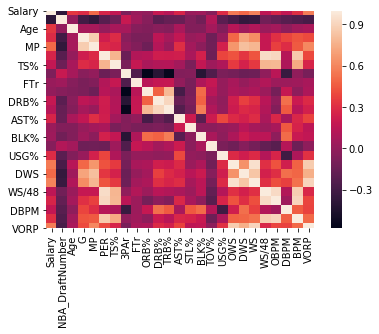

<Figure size 7200x4320 with 0 Axes>

In [9]:
corrMatrix = clean_data.corr()
sn.heatmap(corrMatrix, annot=False)
plt.figure(figsize=(100,60))
plt.show()

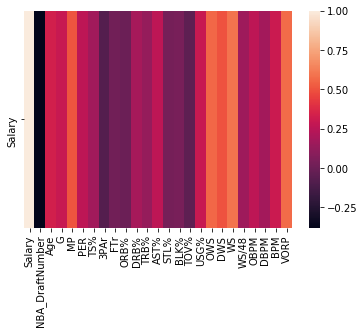

In [26]:
sn.heatmap(corrMatrix[:1], annot=False)
plt.show()

In [24]:
np.array(corrMatrix)[0:1,:]

array([[ 1.00000000e+00, -3.80664126e-01,  3.36000823e-01,
         2.94014490e-01,  5.05095218e-01,  2.66495306e-01,
         1.74758738e-01, -7.35023237e-02,  2.34944909e-02,
         7.47192813e-04,  1.90907283e-01,  1.35331593e-01,
         2.63262857e-01,  3.06574568e-02,  4.20449389e-02,
        -4.32050254e-02,  2.94996071e-01,  5.61988901e-01,
         5.03794351e-01,  5.91306748e-01,  1.60953769e-01,
         2.63521477e-01,  1.78119142e-01,  3.08737429e-01,
         5.73295072e-01]])